In [1]:
from z3 import *
import numpy as np
import matplotlib.pyplot as plt

z3.set_param('parallel.enable', True)
z3.set_param('parallel.threads.max', 32)
z3.set_param('sat.local_search_threads', 3)
z3.set_param('sat.threads', 3)
z3.set_param('sat.lookahead_simplify', True) 

In [2]:
basecond = []

def prove(condition, *precondition):
    # precondition => condition
    # equivalent: not precondition or condition
    # if true not ^ is unsat
    # check precondition and not condition on unsat
    s = Solver()
    s.add(And(*basecond))
    s.add(And(*precondition))
    s.add(Not(condition))
    if s.check() == unsat:
        return "proved"
    else:
        return s.model()

def Prob(name):
    p = Real(name)
    basecond.append(p >= 0)
    basecond.append(p <= 1)
    return p

def ThreePoints(prob, mean, square, t_min, t_max):
    precondition = And(
        0 < prob,
        t_min < mean,
        mean < t_max,
        square - mean**2 >= 0,
        square - mean**2 <= (t_max - mean) * (mean - t_min),
    )
    diff = (square - mean**2) * prob / (t_max - t_min)
    p_min = diff / (mean - t_min)
    p_max = diff / (t_max - mean)
    p_mean = prob - p_min - p_max
    return p_min, p_mean, p_max, precondition

t_min = Real("t_min")
t_max = Real("t_max")
mean = Real("mean")
square = Real("square")
p = Prob("p")

In [3]:
# proof that ThreePoints is correct
p_min, p_mean, p_max, threePointsPrecondition = ThreePoints(p, mean, square, t_min, t_max)
prove(
    And(
        0 <= p_min,
        p_min <= 1,
        0 <= p_mean,
        p_max <= 1,
        0 <= p_max,
        p_max <= 1,
        p == p_min + p_mean + p_max,
        p*mean == p_min * t_min + p_mean * mean + p_max * t_max,
        p*square == p_min * t_min**2 + p_mean * mean**2 + p_max * t_max**2
        
    ),
    threePointsPrecondition
)

'proved'

In [4]:
a = Prob("a")
basecond.append(a > 0)
basecond.append(a < 1)
t = Real("t")
basecond.append(t > t_min)
basecond.append(t < t_max)

Ev = Real("Ev")
Ev0 = Real("Ev_0")
Ev1 = Real("Ev_1")
basecond.append(Ev0 < Ev1)
basecond.append(Ev == a * Ev0 + (1-a) * Ev1)

Sq = Real("Sq")
Sq0 = Real("Sq_0")
Sq1 = Real("Sq_1")
basecond.append(Sq == a * Sq0 + (1-a) * Sq1)
basecond.append(Sq - Ev**2 > 0)
basecond.append(Sq - Ev**2 <= (t_max - Ev)*(Ev - t_min))

d = Sq0 - Ev0**2

p0_min, p0_mean, p0_max, p0cond = ThreePoints(a*p, Ev0, Sq0, t_min, t)
p1_min, p1_mean, p1_max, p1cond = ThreePoints((1-a)*p, Ev1, Sq1, t, t_max)

In [5]:
res = prove(
    And(
        d >= 0,
        d <= (t - Ev0)*(Ev0 - t_min),
        p0_min + p0_mean + p0_max + p1_min + p1_mean + p1_max == p
    ),
    p0cond, p1cond
)
res

'proved'

In [6]:
d1 = Sq1 - Ev1**2
Sq1replace = (Sq - a*Sq0)/(1-a)
Ev1replace = (Ev - a*Ev0)/(1-a)

d1s = substitute(d1, (Sq1, Sq1replace), (Ev1, Ev1replace))
d1f = 1/(1-a)**2 * ((1-a)*(Sq-Ev**2) - a*(1-a)*d - a*(Ev0-Ev)**2)

res = prove(
    And(
        d1 >= 0,
        d1 <= (t_max - Ev1) * (Ev1 - t),
        Ev1 == Ev1replace,
        Sq1 == Sq1replace,
        d1 == d1s,
        d1s == d1f,
        d <= (Sq - Ev**2) / a - (Ev0 - Ev)**2 / (1-a),
        d >= (Sq - Ev**2) / a - (t_max - Ev)*(Ev - t) / a + (t_max - Ev0)*(Ev0 - t)
    ),
    p0cond, p1cond
)
print(res)


d1f

proved


(1/(1 - a)**2)*
((1 - a)*(Sq - Ev**2) -
 a*(1 - a)*(Sq_0 - Ev_0**2) -
 a*(Ev_0 - Ev)**2)

In [7]:
# Auswertung untere und obere Einschränkung von d gegenüberstellen
prove(
    And(
        Ev0 < t, # 1: d0 > und d0 <
        Ev0 > t_min, # 2: d0 > und d0 <
        Ev0 <= Ev/a - (1-a)/a*t, # 3: d1 > und d1 <
        Ev0 >= Ev/a - (1-a)/a*t_max, # 4: d1 > und d1 <
        (Ev0 - Ev)**2 <= (1-a)/a * (Sq - Ev**2), # 5: d0 > und d1 <
        Ev0 <= t - 1/a/(t_max-t_min) * (Sq - Ev**2 - (t_max-Ev)*(Ev-t)), # 6: d0 < und d1 >

        Ev0 < Ev, # (3) mit -t ersetzt durch (1)
    ),
    p0cond, p1cond
)

'proved'

In [8]:
# Auswertung Schranken untere und obere von Ev0 gegenüberstellen
prove(
    And(
        True, # 1 und 2
        a < (t_max - Ev)/(t_max-t), # u1: 1 und 4
        Implies(t < Ev, a <= (Sq - Ev**2)/(Sq - Ev**2 + (Ev-t)**2)), # u2: 1 und 5 >
        a > (t - Ev) / (t - t_min), # l1: 2 und 3
        True, # 2 und 5 <
        # a > (Sq - Ev**2 - (t_max - Ev)*(Ev-t))/(t-t_min)/(t_max-t_min), # l2: 2 und 6
        True, # 3 und 4
        # Implies(t >= Ev, a >= (Ev - t)**2 / ((Ev-t)**2 + Sq - Ev**2)), # l3: 3 und 5 >
        True, # 4 und 5 <
        # a < (t_max - Ev - (Sq - Ev**2 - (t_max -Ev)*(Ev-t))/(t_max-t_min))/(t_max-t)# u3: 4 und 6
        True, # 5 < und 5 >
        # ? # 5 > und 6
        True, # 2 und 7
        True, # 4 und 7
        True, # 5 > und 7
    ),
    p0cond, p1cond
)

'proved'

In [9]:
# Schnitt von u1 und u2 in Punkt
# t = Ev - (Sq - Ev**2) / (t_max - Ev)
# au = (t_max - Ev) / (Sq - Ev**2 + t_max - Ev)

# Schnittpunkt von u3 und 1
# t = Ev + (Sq - Ev**2) / (Ev - t_min)
# a = 1

# Obere Schnittpunkte sind gleich den unteren Schnittpunkten
# für zweiten:
# al = 1 - (Ev - t_min)/(Sq - Ev**2 + Ev - t_min)

# Restliche Schnitte und Reihenfolgen nicht bewiesen, sondern aus der Grafik unten abgelesen

/tmp/ipykernel_3631232/3448294149.py:11: RuntimeWarning: divide by zero encountered in divide
  au1 = (nt_max - nEv)/(nt_max-nt)
/tmp/ipykernel_3631232/3448294149.py:13: RuntimeWarning: divide by zero encountered in divide
  al1 = (nt - nEv) / (nt - nt_min)
/tmp/ipykernel_3631232/3448294149.py:14: RuntimeWarning: divide by zero encountered in divide
  al2 = (nSq - nEv**2 - (nt_max - nEv)*(nEv-nt))/(nt-nt_min)/(nt_max-nt_min)
/tmp/ipykernel_3631232/3448294149.py:16: RuntimeWarning: divide by zero encountered in divide
  au3 = (nt_max - nEv - (nSq - nEv**2 - (nt_max -nEv)*(nEv-nt))/(nt_max-nt_min))/(nt_max-nt)


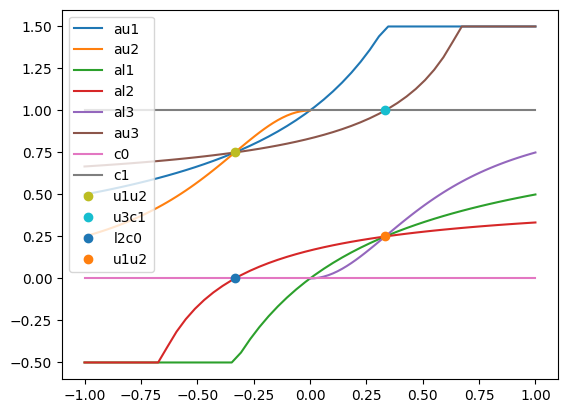

In [10]:
# Bsp für Sq = 1/4, a in Abhängigkeit von t
nSq = 1/3
nt_min = -1
nt_max = +1
nEv = 0

nt0 = np.linspace(nt_min, nEv)
nt1 = np.linspace(nEv, nt_max)
nt  = np.linspace(nt_min, nt_max)

au1 = (nt_max - nEv)/(nt_max-nt)
au2 = (nSq - nEv**2)/(nSq - nEv**2 + (nEv-nt0)**2)
al1 = (nt - nEv) / (nt - nt_min)
al2 = (nSq - nEv**2 - (nt_max - nEv)*(nEv-nt))/(nt-nt_min)/(nt_max-nt_min)
al3 = (nEv - nt1)**2 / ((nEv-nt1)**2 + nSq - nEv**2)
au3 = (nt_max - nEv - (nSq - nEv**2 - (nt_max -nEv)*(nEv-nt))/(nt_max-nt_min))/(nt_max-nt)

fig, ax = plt.subplots()
ax.plot(nt, np.clip(au1, -0.5, 1.5), label="au1")
ax.plot(nt0, np.clip(au2, -0.5, 1.5), label="au2")
ax.plot(nt, np.clip(al1, -0.5, 1.5), label="al1")
ax.plot(nt, np.clip(al2, -0.5, 1.5), label="al2")
ax.plot(nt1, np.clip(al3, -0.5, 1.5), label="al3")
ax.plot(nt, np.clip(au3, -0.5, 1.5), label="au3")
ax.plot([nt_min, nt_max], [0, 0], label="c0")
ax.plot([nt_min, nt_max], [1, 1], label="c1")
ax.plot([nEv - (nSq -nEv**2)/(nt_max - nEv)], [(nt_max -nEv)/(nSq - nEv**2 + nt_max - nEv)], "o", label="u1u2")
ax.plot([nEv + (nSq - nEv**2) / (nEv - nt_min)],[1], "o", label="u3c1")
ax.plot([nEv - (nSq - nEv**2) / (nt_max - nEv)],[0], "o", label="l2c0")
ax.plot([nEv + (nSq -nEv**2)/(nEv - nt_min)], [1 - (nEv - nt_min)/(nSq - nEv**2 + nEv - nt_min)], "o", label="u1u2")
ax.legend()

In [11]:
solve(And(a > 0, 0 >= - 1/Sqrt(a)))

failed to solve
[/0 = [else -> 0]]
